<a href="https://colab.research.google.com/github/Ksenyff/AI/blob/main/design_of_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Документы:
- [пример плана эксперимента](https://docs.google.com/document/d/1z6WkgkI2ZFticx6dgWjyOvmX3FjtCme7/edit?usp=sharing&ouid=104512700084689419560&rtpof=true&sd=true)
- [документ планирования эксперимента](https://docs.google.com/document/d/14sjerL5Hxy1s9UxwpiUPVhPma7mAZtS2kGt7Xg4zcOs/edit?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Построение матрицы планирования полного факторного эксперимента

In [ ]:
!pip install pydoe3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [ ]:
from pyDOE3 import *

In [ ]:
def create_full_factorial_design(factors, normalize=True, append_initial_levels=True, randomize=False):

  # отдельно зададим количество уровней каждого фактора
  factors_levels = [len(factors[factor]) for factor in factors.keys()]

  # рассчитаем матрицу полного факторного планирования
  matrix = fullfact(factors_levels)

  if normalize:
    matrix = normalize_matrix(factors, matrix)
  keys = np.array(list(factors.keys()))

  if append_initial_levels:
    factor_matrix = append_factor_levels(factors, matrix)
    matrix = np.concatenate((matrix, factor_matrix), axis=1)
    keys = np.concat((np.array(list(factors.keys())), np.array(list(factors.keys())) + "_"))

  df = pd.DataFrame(matrix, columns=keys)

  if randomize:
      df = df.sample(frac=1).reset_index(drop=True)

  return df

def append_factor_levels(factors, matrix):

  factor_levels_matrix = matrix.copy()
  # для каждого столбца (фактора)
  for i, (factor, value) in enumerate(factors.items()):

    # возьмем вычисленные уровни фактора
    ffd_levels = np.array(np.unique(factor_levels_matrix[:,i])).reshape(-1)

    # возьмем наши изначальные уровни
    nonscaled_levels = np.array(np.unique(np.array(factors[factor]))).reshape(-1)

    # для удобства зададим словарь соответствия вычисленного уровня фактора нормализованному
    replacement_dict = {level: scaled_level for level, scaled_level in zip(ffd_levels, nonscaled_levels)}

    # поменяем уровень фактора на нормализованный в заданном столбце i
    factor_levels_matrix[:,i] = np.array([replacement_dict.get(x) for x in factor_levels_matrix[:,i]])

  return factor_levels_matrix

def normalize_matrix(factors, matrix):
  # пронормализуем каждый столблец (фактор) матрицы полного факторного планирования в диапазоне [-1, 1]
  scaler = MinMaxScaler(feature_range=(-1, 1))

  # для каждого столбца (фактора)
  for i, (factor, value) in enumerate(factors.items()):

    # возьмем вычисленные уровни фактора
    ffd_levels = np.array(np.unique(matrix[:,i])).reshape(-1)

    # возьмем наши изначальные уровни
    nonscaled_levels = np.array(np.unique(np.array(factors[factor]))).reshape(-1)

    # вычислим соответствующие изначальным уровням нормализованные значения
    scaled_levels = scaler.fit_transform(nonscaled_levels.reshape(-1, 1)).reshape(-1)

    # для удобства зададим словарь соответствия вычисленного уровня фактора нормализованному
    replacement_dict = {level: scaled_level for level, scaled_level in zip(ffd_levels, scaled_levels)}

    # поменяем уровень фактора на нормализованный в заданном столбце i
    matrix[:,i] = np.array([replacement_dict.get(x) for x in matrix[:,i]])

  return matrix

In [ ]:
def encode_category(factors, factor):
  encoder = LabelEncoder()
  for factor_name in [factor]:
    factors[factor_name] = np.sort(encoder.fit_transform(factors[factor_name]))
  return factors

In [ ]:
factors = {
    "planning_horizon": [1.0, 2.0, 3.0, 4.0, 5.0],
    "obstacle_width": [0.1, 0.2, 0.3, 0.4, 0.5]
}

In [ ]:
factors

{'planning_horizon': [1.0, 2.0, 3.0, 4.0, 5.0],
 'obstacle_width': [0.1, 0.2, 0.3, 0.4, 0.5]}

In [ ]:
df = create_full_factorial_design(factors)

In [ ]:
df["obstacle_path"] = df.apply(lambda x: f"/home/aneremin/experiment_ws/src/experiment_package/worlds/wall{int(x.obstacle_width_ * 100)}.sdf" , axis=1)

Мешаем эксперименты между собой (Рандомизация)

In [ ]:
seed = 41
df_shuffled = df.sample(frac=1, random_state=seed)
seed += 1

trials = 10
for i in range(1, trials):
  df_shuffled = pd.concat([df_shuffled, df.sample(frac=1, random_state=seed)], ignore_index=True)
  seed += 1

In [ ]:
df_shuffled = df_shuffled.reset_index()

In [ ]:
df_shuffled.head()

,index,planning_horizon,obstacle_width,planning_horizon_,obstacle_width_,obstacle_path
0,0,-1.0,-0.5,1.0,0.2,/home/aneremin/experiment_ws/src/experiment_pa...
1,1,1.0,0.5,5.0,0.4,/home/aneremin/experiment_ws/src/experiment_pa...
2,2,1.0,0.0,5.0,0.3,/home/aneremin/experiment_ws/src/experiment_pa...
3,3,-1.0,0.0,1.0,0.3,/home/aneremin/experiment_ws/src/experiment_pa...
4,4,0.0,-0.5,3.0,0.2,/home/aneremin/experiment_ws/src/experiment_pa...


In [ ]:
planning_matrix = df_shuffled[["obstacle_path", "planning_horizon_", "obstacle_width_", "index"]].to_numpy()

In [ ]:
planning_matrix.shape

(250, 4)

In [ ]:
np.save("input.npy",planning_matrix)

In [ ]:
np.load("input.npy", allow_pickle=True)

array([['/home/aneremin/experiment_ws/src/experiment_package/worlds/wall20.sdf',
        1.0, 0.2, 0],
       ['/home/aneremin/experiment_ws/src/experiment_package/worlds/wall40.sdf',
        5.0, 0.4, 1],
       ['/home/aneremin/experiment_ws/src/experiment_package/worlds/wall30.sdf',
        5.0, 0.3, 2],
       ['/home/aneremin/experiment_ws/src/experiment_package/worlds/wall30.sdf',
        1.0, 0.3, 3],
       ['/home/aneremin/experiment_ws/src/experiment_package/worlds/wall20.sdf',
        3.0, 0.2, 4],
       ['/home/aneremin/experiment_ws/src/experiment_package/worlds/wall20.sdf',
        4.0, 0.2, 5],
       ['/home/aneremin/experiment_ws/src/experiment_package/worlds/wall40.sdf',
        3.0, 0.4, 6],
       ['/home/aneremin/experiment_ws/src/experiment_package/worlds/wall30.sdf',
        2.0, 0.3, 7],
       ['/home/aneremin/experiment_ws/src/experiment_package/worlds/wall40.sdf',
        1.0, 0.4, 8],
       ['/home/aneremin/experiment_ws/src/experiment_package/worlds/wall2

# Чтение результатов

Получить данные можно по [ссылке](https://drive.google.com/drive/folders/1N8jdjPyFCBOYtAnVPSQ7OrbJ8THqjAFY?usp=sharing)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [ ]:
results_path = "/content/drive/MyDrive/teaching/DCAE/experiment/data/3trials/data.csv"

df = pd.read_csv(results_path, names=["index", "planning_horizon", "obstacle_type", "nav_status", "nav_time", "traveled_distance"], header=0)

In [ ]:
df.shape

(75, 6)

In [ ]:
label_encoder = LabelEncoder()

def get_correct_status(nav_time, nav_status):
  if nav_time < 60.0:
    if nav_status == "ExperimentGoalStatus.CANCELED":
      return "ExperimentGoalStatus.SUCCEEDED"
  else:
    return "ExperimentGoalStatus.CANCELED"

  return nav_status

df["nav_status"] = df.apply(lambda x: get_correct_status(x.nav_time, x.nav_status), axis=1)
df["nav_status_code"] = label_encoder.fit_transform(df["nav_status"])

In [ ]:
df

,index,planning_horizon,obstacle_type,nav_status,nav_time,traveled_distance,nav_status_code
0,0,1.0,1.0,ExperimentGoalStatus.SUCCEEDED,39.628,8.993459,1
1,1,5.0,3.0,ExperimentGoalStatus.SUCCEEDED,36.587,17.101337,1
2,2,5.0,2.0,ExperimentGoalStatus.SUCCEEDED,36.611,16.963272,1
3,3,1.0,2.0,ExperimentGoalStatus.SUCCEEDED,45.188,17.882590,1
4,4,3.0,1.0,ExperimentGoalStatus.SUCCEEDED,32.562,16.935054,1
...,...,...,...,...,...,...,...
70,70,2.0,3.0,ExperimentGoalStatus.SUCCEEDED,31.659,17.068684,1
71,71,2.0,4.0,ExperimentGoalStatus.CANCELED,60.002,13.627177,0
72,72,3.0,3.0,ExperimentGoalStatus.SUCCEEDED,32.163,12.134423,1
73,73,1.0,0.0,ExperimentGoalStatus.SUCCEEDED,33.360,16.889924,1


# Корреляционный анализ

In [ ]:
import seaborn as sns
from scipy import stats

def plot_heatmap(ax, df, title, method='spearman', method_func=stats.spearmanr):
  rho = df.corr(method=method)
  pvalues = df.corr(method=lambda x, y: method_func(x, y)[1]) - np.eye(*rho.shape)

  corrmat_str = pvalues.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
  corrmat_str = rho.round(2).astype(str) + corrmat_str
  sns.heatmap(rho, square=True, annot=corrmat_str, fmt='', ax=ax, cbar_kws={'shrink': 0.5})
  ax.set_title(title, fontsize=20)



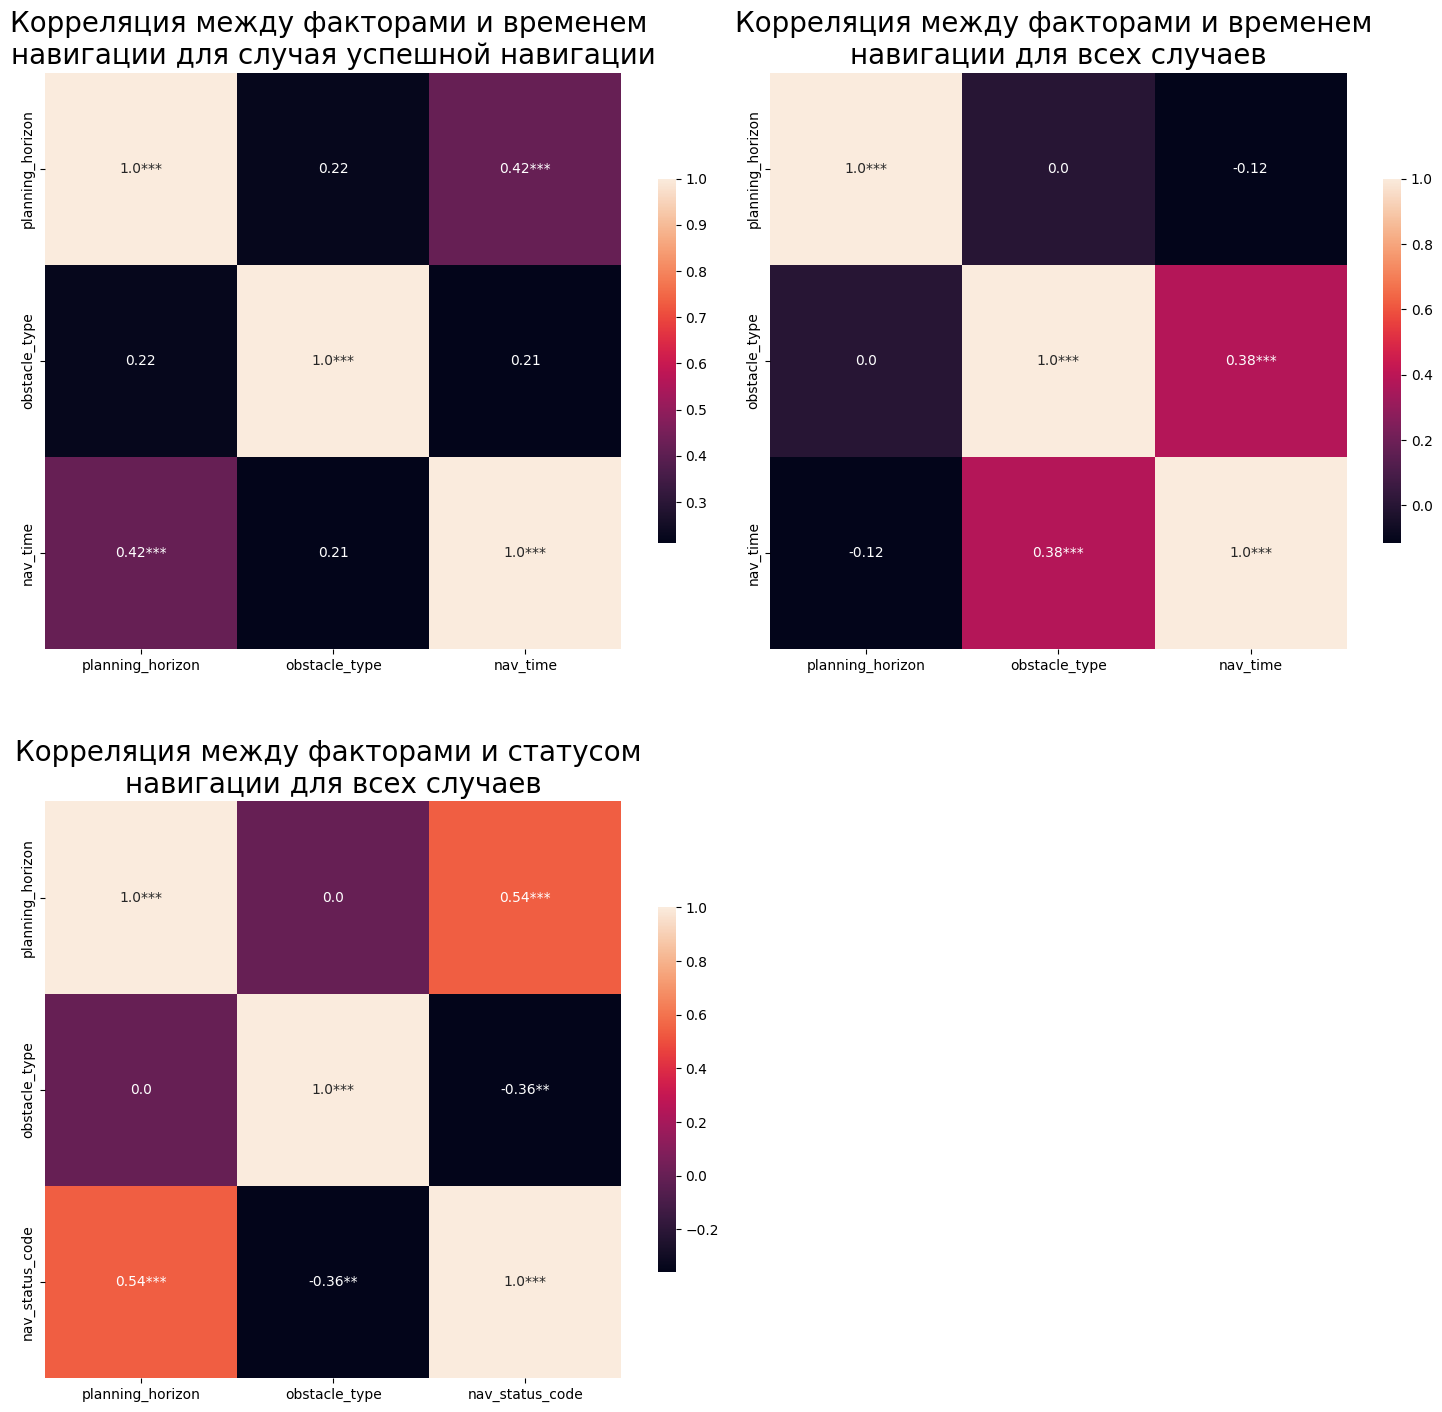

In [ ]:

f, ax = plt.subplots(2, 2, figsize=(15, 15))

filtered_df = df[(df["nav_status_code"] == 1)][["planning_horizon", "obstacle_type", "nav_time"]]
plot_heatmap(ax[0][0], filtered_df, "Корреляция между факторами и временем \nнавигации для случая успешной навигации")

filtered_df = df[["planning_horizon", "obstacle_type", "nav_time"]]
plot_heatmap(ax[0][1], filtered_df, "Корреляция между факторами и временем \nнавигации для всех случаев")


filtered_df = df[["planning_horizon", "obstacle_type", "nav_status_code"]]
plot_heatmap(ax[1][0], filtered_df, "Корреляция между факторами и статусом \nнавигации для всех случаев")

f.delaxes(ax[1][1])

plt.tight_layout()
plt.show()



# Регрессионный анализ

## Группировка данных

Группируем результаты экспериментов относительно факторов

In [ ]:
grouped_df = df.groupby(["planning_horizon","obstacle_type"])['nav_time'].agg(list).reset_index()

Переводим данные в матричный формат

In [ ]:
X = grouped_df[["planning_horizon","obstacle_type"]].to_numpy()
Y = grouped_df["nav_time"].to_numpy()

# переводим list в формат матрицы NumPy
Y = np.array([np.array(i) for i in Y])

print(f"Размер данных:\n  X: {X.shape}\n  Y: {Y.shape}")

Размер данных:
  X: (25, 2)
  Y: (25, 3)


## Проверка воспроизводимости опытов

Вычисляем дисперсию эксперимента

In [ ]:
def get_trial_deviation(Y_j):
  y_j_mean = Y_j.mean()
  m = len(Y_j)
  return np.sum(np.array([(y_ij - y_j_mean) ** 2 for y_ij in Y_j])) / (m - 1)

In [ ]:
n,m = Y.shape
print(f"Количество экспериментов: {n}\nКоличество опытов в каждом эксперименте: {m}")

Количество экспериментов: 25
Количество опытов в каждом эксперименте: 3


Вычисляем дисперсию для каждого эксперимента

In [ ]:
exp_deviation = np.array([get_trial_deviation(Y_j) for Y_j in Y], dtype=np.float32)

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
print(f'Отклонение отклика для каждого эксперимента из {m} опытов:\n', exp_deviation.T)

Отклонение отклика для каждого эксперимента из 3 опытов:
 [ 35.214382   107.28544     73.191055     0.000019     0.00045733
   0.06760433   0.10183233   0.08396234 211.44899      0.000027
   0.387459     0.9938613    0.18042034   0.08342534   0.423003
   0.10763434   0.03010233   0.8947923    0.7191603    0.05741233
   0.21335433   0.55318433   0.232249     0.28432932   0.057964  ]


In [ ]:
def kochran_test(Y, print_res=True):
  deviations = np.array([get_trial_deviation(Y_j) for Y_j in Y])
  kochran = deviations.max() / np.sum(deviations)
  if print_res:
    n,m = Y.shape
    print(f'Значение коэффициента Кохрена для n={n} и f=m-1={m-1}:', kochran)
  return kochran

def exp_reproducible(value, desired_value):
  print(f"Проведенные эксперименты {"" if value < desired_value else "не"} воспроизводимы")

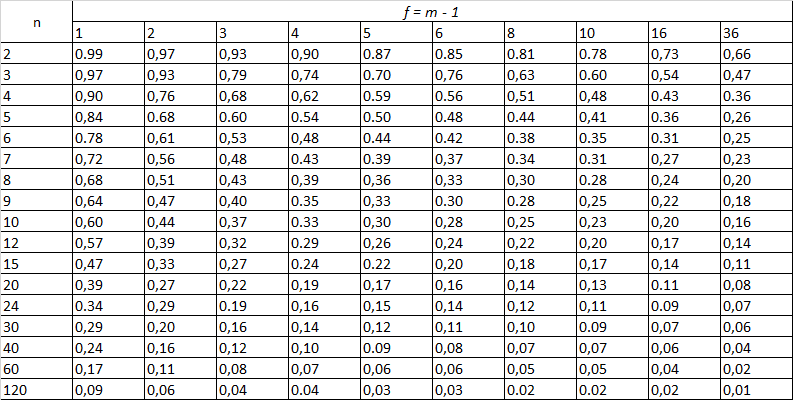

In [ ]:
k = kochran_test(Y)
desired_value_less = 0.2
exp_reproducible(k, desired_value_less)

Значение коэффициента Кохрена для n=25 и f=m-1=2: 0.48877269726971573
Проведенные эксперименты не воспроизводимы


Удалим опыты с большим отклонением

In [ ]:
thres = 2.0
removed_ids = []
for i, d in enumerate(exp_deviation):
  if d > thres:
    print(Y[i], d)
    removed_ids.append(i)

[44.988 41.232 33.36 ] 35.214382
[39.628 53.056 60.003] 107.28544
[45.188 60.01  60.002] 73.191055
[56.574 31.125 31.659] 211.44899


In [ ]:
Y = np.delete(Y, removed_ids, axis=0)
X = np.delete(X, removed_ids, axis=0)

In [ ]:
Y.shape, X.shape

((21, 3), (21, 2))

Проверим, что экспериментов с большими отклонениями не осталось

In [ ]:
thres = 2.0
exp_deviation = [get_trial_deviation(Y_j) for Y_j in Y]
find_deviation = False
for i, d in enumerate(exp_deviation):
  if d > thres:
    find_deviation = True
    print(Y[i], d)

print(f"Отклонения экспериментов больше порога {thres}{"" if find_deviation else " не"} были найдены.")

Отклонения экспериментов больше порога 2.0 не были найдены.


In [ ]:
k = kochran_test(Y)
desired_value_less = 0.2
exp_reproducible(k, desired_value_less)

Значение коэффициента Кохрена для n=21 и f=m-1=2: 0.18161827527255328
Проведенные эксперименты  воспроизводимы


Посчитаем общую ошибку эксперимента

In [ ]:
def get_general_deviation(Y, print_res=True):
  n, m = Y.shape
  deviations = np.array([get_trial_deviation(Y_j) for Y_j in Y])
  dev = np.sum(deviations) / n
  if print_res:
    print(f'Ошибка эксперимента для n={n} и m={m}:', dev)
  return dev

In [ ]:
general_deviation = get_general_deviation(Y)

Ошибка эксперимента для n=21 и m=3: 0.260583523809524


Возьмем среднее значение отклика

In [ ]:
Y_mean = np.mean(Y, axis=1)

In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_3d(x, y, z, color):

  fig = go.Figure(data=[go.Scatter3d(
      x=x,
      y=y,
      z=z,
      mode='markers',
      marker=dict(
          size=4,
          color=z,
          colorscale='Viridis',
          opacity=0.8
      )
  )])

  fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
  fig.show()

In [ ]:
plot_3d(*X.T, Y_mean, Y_mean)

In [ ]:
outliers_indexes = np.where(Y_mean > 50.0)[0]

In [ ]:
Y_mean = np.delete(Y_mean, outliers_indexes, axis=0)
X = np.delete(X, outliers_indexes, axis=0)
Y = np.delete(Y, outliers_indexes, axis=0)

In [ ]:
k = kochran_test(Y)
desired_value_less = 0.2
exp_reproducible(k, desired_value_less)
general_deviation = get_general_deviation(Y)

Значение коэффициента Кохрена для n=18 и f=m-1=2: 0.18163498190585148
Проведенные эксперименты  воспроизводимы
Ошибка эксперимента для n=18 и m=3: 0.30398614814814834


In [ ]:
Y.shape, X.shape, Y_mean.shape

((18, 3), (18, 2), (18,))

In [ ]:
plot_3d(*X.T, Y_mean, Y_mean)

## Поиск регрессии

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(X_poly, Y_mean)

LinearRegression()

In [ ]:
Y_pred = model.predict(X_poly)

In [ ]:
plot_3d(*X.T, Y_pred, Y_pred)

In [ ]:
x = np.linspace(2, 5, 50).reshape(-1, 1)
y = np.linspace(0, 4, 50).reshape(-1, 1)
X_pred = np.concat([x,y], axis=1)
X_poly_pred = poly_features.fit_transform(X_pred)
Y_full_pred = model.predict(X_poly_pred)

In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_surface(x, y, z, title="График поверхности"):

  fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
  fig.update_layout(title=title, autosize=False,
                      scene_camera_eye=dict(x=1.86, y=0.18, z=0.64),
                      width=700, height=700,
                      margin=dict(l=65, r=50, b=65, t=90))
  fig.show()

In [ ]:
X_grid, Y_grid = np.meshgrid(*X_pred.T)
Y_pred_grid = np.tile(Y_full_pred, (len(Y_full_pred), 1))

plot_surface(X_grid, Y_grid, Y_pred_grid)

## Проверка значимости коэффициентов (параметров) регрессии

In [ ]:
def get_coef_deviation(Y, n, m, print_res=True):
  dev = np.sqrt(get_general_deviation(Y, print_res=print_res) / (m * n))
  if print_res:
    print(f'Среднее квадратическое отклонение коэффициентов n={n} и m={m}:', dev)
  return dev

In [ ]:
coefs = np.concatenate([np.array([model.intercept_]), model.coef_])

In [ ]:
coef_deviation = get_coef_deviation(Y, Y.shape[0], coefs.shape[0])

Ошибка эксперимента для n=18 и m=3: 0.30398614814814834
Среднее квадратическое отклонение коэффициентов n=18 и m=6: 0.05305361964020268


In [ ]:
def get_coef_significance(Y, n, m, coef, print_res=False):
  return np.abs(coef) / get_coef_deviation(Y, n, m, print_res=print_res)

In [ ]:
def coefficient_significant(value, desired_value):
  print(f"Коэффициент {value}{"" if value >= desired_value else " не"} является значимым.")

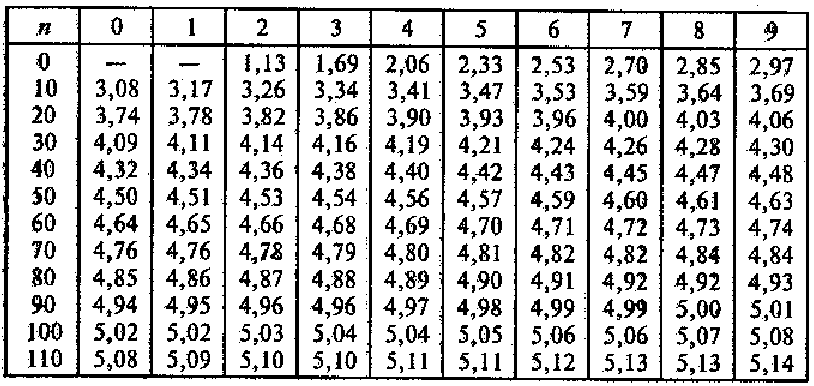

Вид полученной нами функции

$$
Y = b_0 + b_1 x_1 + b_2 x_2 + b_3 x_1^2 + b_4 x_2^2 + b_5 x_1 x_2
$$

In [ ]:
desired_value = 4.24
values = np.array([get_coef_significance(Y, Y.shape[0], coefs.shape[0], coef) for coef in coefs])
print(f'Значение расчетного значения t-критерия значимости коэффициентов для n={n}, m={coefs.shape[0]}:')
for value in values:
  coefficient_significant(value, desired_value)

Значение расчетного значения t-критерия значимости коэффициентов для n=25, m=6:
Коэффициент 587.0538133397333 является значимым.
Коэффициент 28.519189600303854 является значимым.
Коэффициент 5.233719881171481 является значимым.
Коэффициент 9.522348493533707 является значимым.
Коэффициент 1.0397645631988228 не является значимым.
Коэффициент 1.3710487800668059 не является значимым.


После исключения незначимых коэффициентов получим

$$
Y = b_0 + b_1 x_1 + b_2 x_2 + b_3 x_1^2
$$

## Проверка адекватности построенной регрессионной модели

Воспользуемся [коэффициентом детерминации](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8)

In [ ]:
Y.shape, Y_pred.shape, Y_mean.shape

((18, 3), (18,), (18,))

Предварительно уберем из модели 5 и 6 коэффициенты

In [ ]:
X_poly_croped = X_poly
X_poly_croped[:,4] = 0
X_poly_croped[:,3] = 0

Y_pred_croped = model.predict(X_poly_croped)

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

In [ ]:
r2 = r2_score(Y_mean, Y_pred_croped)
print(f"R-squared score: {r2}")

R-squared score: 0.9848625157233541


Положение метрики $R^2$ близко к 1, что говорит о том, что предсказанные значения близки к изначальным

In [ ]:
x = np.linspace(2, 5, 50).reshape(-1, 1)
y = np.linspace(0, 4, 50).reshape(-1, 1)
X_pred = np.concat([x,y], axis=1)

X_poly_pred = poly_features.fit_transform(X_pred)
X_poly_pred[:,4] = 0
X_poly_pred[:,3] = 0
Y_full_pred = model.predict(X_poly_pred)

X_grid, Y_grid = np.meshgrid(*X_pred.T)
Y_pred_grid = np.tile(Y_full_pred, (len(Y_full_pred), 1))

plot_surface(X_grid, Y_grid, Y_pred_grid)